_Imports_

In [ ]:
import os 
import re
import nltk
import torch
import random
import shutil
import warnings
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sacrebleu.metrics import BLEU
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.models import resnet50, ResNet50_Weights
from transformers import AutoProcessor, AutoModelForVision2Seq
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

warnings.filterwarnings("ignore")
nltk.data.find('tokenizers/punkt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2025-11-16 12:25:15.222714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763295915.244806     189 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763295915.251503     189 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


_Folder Paths_

In [2]:
projectDir = os.getcwd()
dataDir = os.path.join(projectDir, "data")
imagesDir = os.path.join(dataDir, "images")
modelsDir = os.path.join(projectDir, "models")
trainImages = os.path.join(dataDir, "trainImages")
trainCaptions = os.path.join(dataDir, "trainCaptions")
testImages = os.path.join(dataDir, "testImages")
testCaptions = os.path.join(dataDir, "testCaptions")
valImages = os.path.join(dataDir, "valImages")
valCaptions = os.path.join(dataDir, "valCaptions")

_Split Data into Train/Test/Validation_

In [4]:
# create folders if not exist
for folder in [trainImages, trainCaptions, testImages,
               testCaptions, valImages, valCaptions]:
    os.makedirs(folder, exist_ok=True)

# the number of samples for train/test/val
trainSize, testSize, valSize = 6500, 500, 1091

# read the captions data, group them and shuffle
captionsDF = pd.read_csv(os.path.join(dataDir, "captions.txt"))
grouped = captionsDF.groupby("image")["caption"].apply(list).reset_index()
grouped = grouped.sample(frac=1, random_state=42).reset_index(drop=True)

# split to sub dataframes based on train/test/val sizes
train_data = grouped.iloc[:trainSize]
test_data = grouped.iloc[trainSize:trainSize + testSize]
val_data = grouped.iloc[trainSize + testSize:]

# copy train images and captions 
print("📦 Moving data...")
for _, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Train split"):
    if os.path.exists(os.path.join(imagesDir, row["image"])):
        shutil.copy(os.path.join(imagesDir, row["image"]), os.path.join(trainImages, row["image"]))

    captionFile = os.path.splitext(row["image"])[0] + ".txt"
    with open(os.path.join(trainCaptions, captionFile), "w", encoding="utf-8") as f:
        for caption in row["caption"]:
            f.write(caption.strip() + "\n")

# copy test images and captions 
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Test split"):
    if os.path.exists(os.path.join(imagesDir, row["image"])):
        shutil.copy(os.path.join(imagesDir, row["image"]), os.path.join(testImages, row["image"]))

    cap_file = os.path.splitext(row["image"])[0] + ".txt"
    with open(os.path.join(testCaptions, cap_file), "w", encoding="utf-8") as f:
        for caption in row["caption"]:
            f.write(caption.strip() + "\n")

# copy validation images and captions 
for _, row in tqdm(val_data.iterrows(), total=len(val_data), desc="Val split"):
    if os.path.exists(os.path.join(imagesDir, row["image"])):
        shutil.copy(os.path.join(imagesDir, row["image"]), os.path.join(valImages, row["image"]))

    cap_file = os.path.splitext(row["image"])[0] + ".txt"
    with open(os.path.join(valCaptions, cap_file), "w", encoding="utf-8") as f:
        for caption in row["caption"]:
            f.write(caption.strip() + "\n")

print("✅ Data successfully split into train/test/val folders!")

📦 Moving data...


Val split: 100%|██████████| 1091/1091 [00:20<00:00, 53.82it/s]

✅ Data successfully split into train/test/val folders!


_Visualize Training Data_

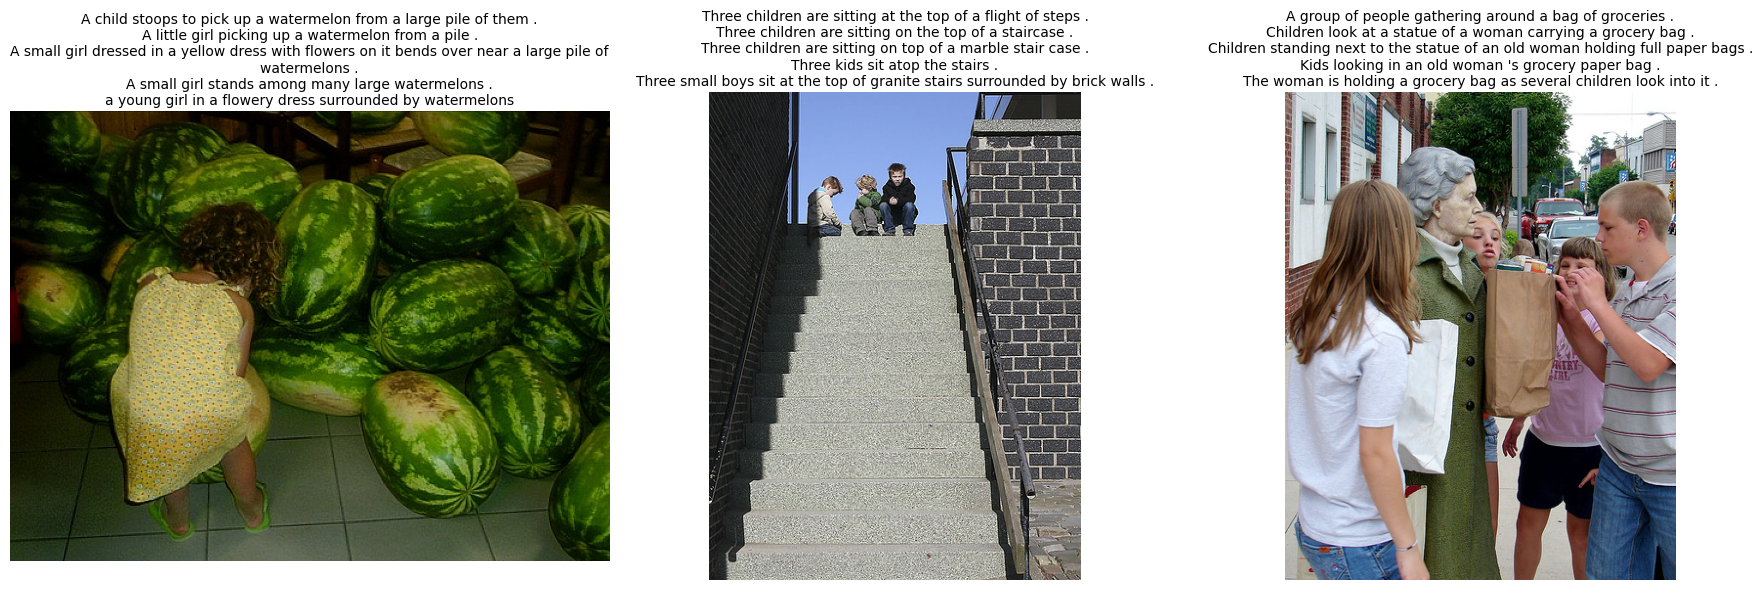

In [8]:
# select 3 random images from train set to display
samples = random.sample(os.listdir(trainImages), 3)

plt.figure(figsize=(18, 6))
for i, imgName in enumerate(samples):
    imgPath = os.path.join(trainImages, imgName)
    capPath = os.path.join(trainCaptions, os.path.splitext(imgName)[0] + ".txt")
    image = Image.open(imgPath).convert("RGB")

    # get captions of the specific image and combine them
    with open(capPath, "r", encoding="utf-8") as f:
        captions = f.read().strip().split("\n")
    captionText = "\n".join(captions)

    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(captionText, fontsize=10, loc="center", wrap=True)

plt.tight_layout()
plt.show()

_Build a Vocabulary_

In [12]:
class Vocabulary:
    def __init__(self, freqThresh=3):
        # min number of appearance of a word to be included to vocabulary
        self.freqThresh = freqThresh
        # stores words and their ids as value
        self.word2idx = {}
        # stores ids and the corresponding words as values
        self.idx2word = {}
        # count words so we'll not include less frequent words
        self.wordFreq = Counter()

        # special tokens
        self.PAD_TOKEN = '<pad>'
        self.START_TOKEN = '<start>'
        self.END_TOKEN = '<end>'
        self.UNK_TOKEN = '<unk>'
        
        self.word2idx[self.PAD_TOKEN] = 0
        self.word2idx[self.START_TOKEN] = 1
        self.word2idx[self.END_TOKEN] = 2
        self.word2idx[self.UNK_TOKEN] = 3
        
        self.idx2word[0] = self.PAD_TOKEN
        self.idx2word[1] = self.START_TOKEN
        self.idx2word[2] = self.END_TOKEN
        self.idx2word[3] = self.UNK_TOKEN
        
        self.idx = 4

    # function to split sentences into words and normalize them
    def tokenize(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\']', ' ', text)
        words = text.split()
        return words
        
    # function that builds idx:word and word:idx pairs
    def buildVocabulary(self, captionsList):
        for caption in captionsList:
            words = self.tokenize(caption)
            self.wordFreq.update(words)
        
        for word, freq in self.wordFreq.items():
            if freq >= self.freqThresh:
                if word not in self.word2idx:
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
                    self.idx += 1

    # function to convert a text into tokens
    def numericalize(self, text):
        words = self.tokenize(text)
        return [self.word2idx.get(word, self.word2idx[self.UNK_TOKEN]) for word in words]

    def __len__(self):
        return len(self.word2idx)

    # returns the token of input word
    def __getitem__(self, word):
        return self.word2idx.get(word, self.word2idx[self.UNK_TOKEN])

# loop that iterates over train captions and build the vocabulary
allCaptions = []
for captionFile in tqdm(os.listdir(trainCaptions), desc="Reading captions"):
    captionPath = os.path.join(trainCaptions, captionFile)
    with open(captionPath, 'r', encoding='utf-8') as f:
        captions = f.read().strip().split('\n')
        allCaptions.extend(captions)

vocabulary = Vocabulary(freqThresh=2)
vocabulary.buildVocabulary(allCaptions)
print(f"Vocabulary was created with size: {len(vocabulary)}")

Reading captions: 100%|██████████| 6500/6500 [00:01<00:00, 5023.79it/s]


Vocabulary was created with size: 4709


_Visualize Some Tokens from Vocabulary_

In [13]:
print("Some Sample Tokens from Vocabulary:")
for key, value in list(vocabulary.word2idx.items())[10:20]:
    print(f"{value} - <{key}>")

Some Sample Tokens from Vocabulary:
10 - <climbing>
11 - <up>
12 - <set>
13 - <of>
14 - <stairs>
15 - <an>
16 - <way>
17 - <girl>
18 - <going>
19 - <into>


_Create Dataset_

In [ ]:
class ICDataset(Dataset):    
    def __init__(self, imagesDir, captionsDir, vocabulary, transform=None):
        self.imagesDir = imagesDir
        self.captionsDir = captionsDir
        self.vocabulary = vocabulary
        self.transform = transform
        # list to store image, caption pairs
        self.pairs = []

        # get all images
        imageFiles = [file for file in os.listdir(imagesDir) if file.endswith(('.jpg'))]
        
        for imgName in imageFiles:
            captionFile = os.path.splitext(imgName)[0] + '.txt'
            captionPath = os.path.join(self.captionsDir, captionFile)
            
            # read captions from text file
            with open(captionPath, 'r', encoding='utf-8') as f:
                captions = f.read().strip().split('\n')
            
            # add image, caption pairs to the list
            for caption in captions:
                if caption.strip():
                    self.pairs.append((imgName, caption))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        imgName, caption = self.pairs[idx]
        imgPath = os.path.join(self.imagesDir, imgName)
        image = Image.open(imgPath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # convert caption text into a list of word ids
        numericalizedCaption = [self.vocabulary.word2idx[self.vocabulary.START_TOKEN]]
        numericalizedCaption.extend(self.vocabulary.numericalize(caption))
        numericalizedCaption.append(self.vocabulary.word2idx[self.vocabulary.END_TOKEN])

        return image, torch.tensor(numericalizedCaption, dtype=torch.long)

# train augumentations
trainTransform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    # mean and standard deviation of each color channel (RGB) in the ImageNet dataset
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# evaluation augumentations
evalTransform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# create datasets
trainDataset = ICDataset(trainImages, trainCaptions, vocabulary, transform=trainTransform)
valDataset = ICDataset(valImages, valCaptions, vocabulary, transform=evalTransform)
testDataset = ICDataset(testImages, testCaptions, vocabulary, transform=evalTransform)

print(f"Train dataset size: {len(trainDataset)}")
print(f"Val dataset size: {len(valDataset)}")
print(f"Test dataset size: {len(testDataset)}")

Train dataset size: 32500
Val dataset size: 5455
Test dataset size: 2500


_Create DataLoaders_

In [15]:
# this function prepares a batch of images and captions to feed into the model
def collate(batch):
    images, captions = [], []

    for image, caption in batch:
        images.append(image)
        captions.append(caption)

    # stack images into a single tensor
    images = torch.stack(images, dim=0)
    # fill the captions with <pad> and make them same length
    captions = pad_sequence(captions, batch_first=True, padding_value=vocabulary.word2idx[vocabulary.PAD_TOKEN])
    return images, captions

batchSize = 48
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True, collate_fn=collate, num_workers=2)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False, collate_fn=collate, num_workers=2)
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False, collate_fn=collate, num_workers=2)

print(f"Train batches: {len(trainLoader)}")
print(f"Validation batches: {len(valLoader)}")
print(f"Test batches: {len(testLoader)}")

Train batches: 678
Validation batches: 114
Test batches: 53


_Encoder Module_

In [16]:
# here we'll partially fine-tune resnet model...
class EncoderCNN(nn.Module):
    def __init__(self, embedSize=256):
        super(EncoderCNN, self).__init__()
        # load resnet model
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        # remove the last two layers (avgpool and fully connected layer)
        # because we only need the convolutional part for feature extraction
        modules = list(resnet.children())[:-2]
        # combine the remaining layers in one single sequential module
        self.resnet = nn.Sequential(*modules)

        # freeze all layers 
        for param in self.resnet.parameters():
            param.requires_grad = False

        # unfreeze the last convolution block to fine-tune it
        for param in self.resnet[-1].parameters():  
            param.requires_grad = True

        # fix the size of feature maps 
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))
        # linear layer to shrink vectors
        self.linear = nn.Linear(resnet.fc.in_features, embedSize)

    def forward(self, images):
        with torch.set_grad_enabled(self.training):
            # send image to resnet to get feature maps
            features = self.resnet(images)
        features = self.adaptive_pool(features)
        # change the order of dimensions
        features = features.permute(0, 2, 3, 1)
        batch_size = features.size(0)
        # flatten 14x14 grid into a vector
        features = features.view(batch_size, -1, features.size(-1))
        features = self.linear(features)
        return features

_Attention Module_

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoderDim, decoderDim, attentionDim):
        super(Attention, self).__init__()
        
        # convert encoder and decoder features into smaller attention features
        self.encoderAtt = nn.Linear(encoderDim, attentionDim)
        self.decoderAtt = nn.Linear(decoderDim, attentionDim)
        
        # combine encoder, decoder and make a single score for each image region
        self.fullAtt = nn.Linear(attentionDim, 1)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, encoderOut, decoderHidden):
        
        # get attention features from encoder and decoder output
        att1 = self.encoderAtt(encoderOut)
        att2 = self.decoderAtt(decoderHidden)
        
        # add them together, apply relu, and make a score for each pixel
        att = self.fullAtt(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        
        # apply dropout if it is training
        att = self.dropout(att) if self.training else att
        
        # turn scores into probabilities
        alpha = self.softmax(att)
        
        # multiply image features by their attention weights and sum up
        attentionWeightedEncoding = (encoderOut * alpha.unsqueeze(2)).sum(dim=1)
        return attentionWeightedEncoding, alpha

_Decoder Module_

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, attentionDim, embedDim, decoderDim, vocabSize, encoderDim=256, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.attentionDim = attentionDim
        self.embedDim = embedDim
        self.decoderDim = decoderDim
        self.vocabSize = vocabSize
        self.encoderDim = encoderDim
        self.dropout = dropout

        # create the attention model
        self.attention = Attention(encoderDim, decoderDim, attentionDim)
        # turn ids into word embeddings
        self.embedding = nn.Embedding(vocabSize, embedDim)
        # drop out some neurons randomly to prevent overfitting
        self.embeddingDropout = nn.Dropout(p=self.dropout * 0.5)
        self.dropoutLayer = nn.Dropout(p=self.dropout)

        # lstm that predicts next word using current word + image info
        self.decodeStep = nn.LSTMCell(embedDim + encoderDim, decoderDim, bias=True)

        # initialize hidden state and cell state
        self.initH = nn.Linear(encoderDim, decoderDim)
        self.initC = nn.Linear(encoderDim, decoderDim)

        # decide how much image info to use at each step
        self.fBeta = nn.Linear(decoderDim, encoderDim)
        self.sigmoid = nn.Sigmoid()

        # final layer that predicts the next word
        self.fc = nn.Linear(decoderDim, vocabSize)
        self.initWeights()

    def initWeights(self):
        # set small random values for embedding weights
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        # set all final layer biases to zero
        self.fc.bias.data.fill_(0)
        # set small random values for final layer weights
        self.fc.weight.data.uniform_(-0.1, 0.1)

    # using encoder output initalize the hidden state and cell state
    def initHiddenState(self, encoderOut):
        batchSize = encoderOut.size(0)
        attentionWeightedEncoding, _ = self.attention(encoderOut, torch.zeros(batchSize, self.decoderDim, device=encoderOut.device))
        h = self.initH(attentionWeightedEncoding)
        c = self.initC(attentionWeightedEncoding)
        return h, c

    def forward(self, encoderOut, encodedCaptions, captionLengths, teacherForcingRatio=1.0):
        # get batch size and feature dimensions
        batchSize = encoderOut.size(0)
        encoderDim = encoderOut.size(-1)
        vocabSize = self.vocabSize

        # flatten image features
        encoderOut = encoderOut.view(batchSize, -1, encoderDim)
        numPixels = encoderOut.size(1)

        # sort captions by length
        captionLengths, sortInd = captionLengths.squeeze(1).sort(dim=0, descending=True)

        # reorder encoder outputs and captions by sorted indices
        encoderOut = encoderOut[sortInd]
        encodedCaptions = encodedCaptions[sortInd]

        # turn words into embeddings
        embeddings = self.embedding(encodedCaptions)

        # apply dropout to embeddings during training
        embeddings = self.embeddingDropout(embeddings) if self.training else embeddings

        # get initial hidden and cell states
        h, c = self.initHiddenState(encoderOut)

        # compute how long each caption (minus <end> token)
        decodeLengths = (captionLengths - 1).tolist()

        # prepare empty tensors to store predictions and attention weights
        predictions = torch.zeros(batchSize, max(decodeLengths), vocabSize, device=encoderOut.device)
        alphas = torch.zeros(batchSize, max(decodeLengths), numPixels, device=encoderOut.device)

        # start decoding with <start> tokens
        prevWords = encodedCaptions[:, 0].clone()

        # loop through each time step
        for t in range(max(decodeLengths)):
            # only keep samples that still have words left
            batchSizeT = sum([l > t for l in decodeLengths])

            # apply attention to focus on image parts for current step
            attentionWeightedEncoding, alpha = self.attention(encoderOut[:batchSizeT], h[:batchSizeT])

            # gate to control how much of the image info we use
            gate = self.sigmoid(self.fBeta(h[:batchSizeT]))
            attentionWeightedEncoding = gate * attentionWeightedEncoding

            # choose input word embedding for this step
            if t == 0:
                # first word always uses <start> token
                currentEmbeddings = embeddings[:batchSizeT, t, :]
            else:
                # randomly decide to use teacher forcing (true word) or model's prediction
                teacherMask = torch.rand(batchSizeT, device=encoderOut.device) < teacherForcingRatio

                # create empty space for embeddings
                currentEmbeddings = torch.zeros(batchSizeT, self.embedDim, device=encoderOut.device)

                # use real word embeddings when teacher forcing applies
                if teacherMask.any():
                    currentEmbeddings[teacherMask] = embeddings[:batchSizeT, t, :][teacherMask]

                # use model’s own predicted words otherwise
                if (~teacherMask).any():
                    sampledTokens = prevWords[:batchSizeT][~teacherMask]
                    emb = self.embedding(sampledTokens)
                    if self.training:
                        emb = self.embeddingDropout(emb)
                    currentEmbeddings[~teacherMask] = emb

            # run one decoding step through LSTMCell
            h, c = self.decodeStep(
                torch.cat([currentEmbeddings, attentionWeightedEncoding], dim=1),
                (h[:batchSizeT], c[:batchSizeT])
            )

            # predict next word from lstm output
            preds = self.fc(self.dropoutLayer(h))

            # save predictions and attention weights
            predictions[:batchSizeT, t, :] = preds
            alphas[:batchSizeT, t, :] = alpha

            # update previous words with newly predicted tokens
            newPrevWords = prevWords.clone()
            newPrevWords[:batchSizeT] = preds.argmax(1)
            prevWords = newPrevWords

        # return predictions, captions, decode lengths, sorting info, and attention maps
        return predictions, encodedCaptions, decodeLengths, sortInd, alphas

_Image Captioning Model_

In [19]:
# this model combines our encoder, decoder and attention modules in one pipeline 
class ImageCaptionModel(nn.Module):
    def __init__(self, attentionDim=256, embedDim=256, decoderDim=512, vocabSize=None, encoderDim=256, dropout=0.5):
        super(ImageCaptionModel, self).__init__()
        
        # create the cnn encoder based on resnet and...
        # rnn decoder with attention mechanism
        self.encoder = EncoderCNN(encoderDim)
        self.decoder = DecoderRNN(attentionDim, embedDim, decoderDim, vocabSize, encoderDim, dropout)

    def forward(self, images, encodedCaptions, captionLengths, teacherForcingRatio=1.0):
        # pass image to encoder cnn to get feature maps
        encoderOut = self.encoder(images)
        
        # pass encoder outputs and captions to decoder to predict next words
        predictions, encodedCaptions, decodeLengths, sortInd, alphas = self.decoder(
            encoderOut, encodedCaptions, captionLengths,
            teacherForcingRatio=teacherForcingRatio
        )

        # return decoder's predictions
        return predictions, encodedCaptions, decodeLengths, sortInd, alphas


vocabSize = len(vocabulary)

# define model dimensions
attentionDim = 256
embedDim = 256
decoderDim = 512
encoderDim = 256     

# initalize full image captioning model
model = ImageCaptionModel(
    attentionDim=attentionDim,
    embedDim=embedDim,
    decoderDim=decoderDim,
    vocabSize=vocabSize,
    encoderDim=encoderDim,
    dropout=0.50
).to(device)

# Calculate number of parameters in ResNet layer4 that are being fine-tuned
resnetFinetuned = sum(p.numel() for p in model.encoder.resnet[-1].parameters() if p.requires_grad)
# Calculate parameters in the encoder’s final linear layer
encoderLinear = sum(p.numel() for p in model.encoder.linear.parameters())
# Calculate total number of parameters in the decoder
decoderParams = sum(p.numel() for p in model.decoder.parameters())

# Print breakdown of where trainable parameters come from
print(f"ResNet fine-tuned: {resnetFinetuned:,} parameters")
print(f"Encoder linear layer: {encoderLinear:,} parameters")
print(f"Decoder: {decoderParams:,} parameters")

ResNet fine-tuned: 14,964,736 parameters
Encoder linear layer: 524,544 parameters
Decoder: 6,314,342 parameters


_Training Setup_

In [20]:
# use crossentropy loss and ignore padding tokens
criterion = nn.CrossEntropyLoss(ignore_index=vocabulary.word2idx[vocabulary.PAD_TOKEN])

# get trainable parameters
encoderFinetunedParams = list(model.encoder.resnet[-1].parameters())
encoderLinearParams = list(model.encoder.linear.parameters())
encoderTrainableParams = encoderFinetunedParams + encoderLinearParams
decoderParams = list(model.decoder.parameters())

# create optimizer with different learning rates for encoder and decoder
optimizer = torch.optim.Adam([
    {"params": decoderParams, "lr": 1e-4, "weight_decay": 3e-4},
    {"params": encoderTrainableParams, "lr": 1e-5, "weight_decay": 3e-4}
])

# function to train model for one epoch
def trainEpoch(model, dataLoader, criterion, optimizer, device, teacherForcingRatio):
    model.train()
    totalLoss = 0

    # loop over the batches of images
    for images, captions in tqdm(dataLoader, desc="Training"):
        images = images.to(device)
        captions = captions.to(device)

        # compute how many real tokens are in the caption (without padding tokens)
        captionLengths = torch.tensor([torch.sum(cap != vocabulary.word2idx[vocabulary.PAD_TOKEN]).item() for cap in captions]).unsqueeze(1).to(device)
        # forward pass
        predictions, encodedCaptions, decodeLengths, sortInd, alphas = model(images, captions, captionLengths, teacherForcingRatio=teacherForcingRatio)
        targets = encodedCaptions[:, 1:]

        # pack sequences to remove padding before computing loss
        predictions = pack_padded_sequence(predictions, decodeLengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decodeLengths, batch_first=True).data
        # compute loss between predicted and target words
        loss = criterion(predictions, targets)

        # clear old gradients
        optimizer.zero_grad()
        # backpropagate to compute gradients
        loss.backward()
        # clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        # update weights using optimizer
        optimizer.step()
        totalLoss += loss.item()

    return totalLoss / len(dataLoader)

# function to evaluate model
def validate(model, dataLoader, criterion, device, vocabulary):
    model.eval()
    totalLoss = 0

    # disable gradient calculations for faster validation
    with torch.no_grad():
        for images, captions in tqdm(dataLoader, desc="Computing Loss"):
            images = images.to(device)
            captions = captions.to(device)

            # compute caption lengths
            captionLengths = torch.tensor([torch.sum(cap != vocabulary.word2idx[vocabulary.PAD_TOKEN]).item() for cap in captions]).unsqueeze(1).to(device)
            # Forward pass through encoder and decoder
            predictions, encodedCaptions, decodeLengths, sortInd, alphas = model(images, captions, captionLengths, teacherForcingRatio=1.0)
            targets = encodedCaptions[:, 1:]

            # pack sequences
            predictions = pack_padded_sequence(predictions, decodeLengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decodeLengths, batch_first=True).data

            # compute validation loss
            loss = criterion(predictions, targets)
            totalLoss += loss.item()

    return totalLoss / len(dataLoader)

def calculateBLEUScores(model, valImagesDir, valCaptionsDir, vocabulary, evalTransform, device):
    model.eval()
    bleu1Metric = BLEU(max_ngram_order=1)
    bleu2Metric = BLEU(max_ngram_order=2)
    bleu3Metric = BLEU(max_ngram_order=3)
    bleu4Metric = BLEU(max_ngram_order=4)
    
    allPredictions = []
    allReferences = []
    
    imageFiles = [f for f in os.listdir(valImagesDir) if f.endswith('.jpg')]
    
    with torch.no_grad():
        for imgName in tqdm(imageFiles, desc="Computing BLEU"):
            imgPath = os.path.join(valImagesDir, imgName)
            capFile = os.path.splitext(imgName)[0] + '.txt'
            capPath = os.path.join(valCaptionsDir, capFile)
            
            image = Image.open(imgPath).convert('RGB')
            imageTensor = evalTransform(image).unsqueeze(0).to(device)
            
            with open(capPath, 'r', encoding='utf-8') as f:
                trueCaptions = [line.strip() for line in f.readlines() if line.strip()]
            
            encoderOut = model.encoder(imageTensor)
            encoderDim = encoderOut.size(-1)
            numPixels = encoderOut.size(1)
            encoderOut = encoderOut.view(1, numPixels, encoderDim)
            
            startToken = vocabulary.word2idx[vocabulary.START_TOKEN]
            endToken = vocabulary.word2idx[vocabulary.END_TOKEN]
            
            h, c = model.decoder.initHiddenState(encoderOut)
            seq = [startToken]
            
            for _ in range(50):
                embeddings = model.decoder.embedding(torch.tensor([seq[-1]], device=device))
                attentionWeightedEncoding, alpha = model.decoder.attention(encoderOut, h)
                gate = model.decoder.sigmoid(model.decoder.fBeta(h))
                attentionWeightedEncoding = gate * attentionWeightedEncoding
                h, c = model.decoder.decodeStep(torch.cat([embeddings, attentionWeightedEncoding], dim=1), (h, c))
                scores = model.decoder.fc(h)
                nextWord = scores.argmax(1).item()
                if nextWord == endToken:
                    break
                seq.append(nextWord)
            
            tokens = []
            for idx in seq[1:]:
                if idx == endToken:
                    break
                tokens.append(vocabulary.idx2word[idx])
            predCaption = ' '.join(tokens)
            
            allPredictions.append(predCaption)
            allReferences.append(trueCaptions)
    
    numRefs = max(len(refs) for refs in allReferences)
    transposedRefs = []
    for refIdx in range(numRefs):
        transposedRefs.append([refs[refIdx] if refIdx < len(refs) else refs[0] for refs in allReferences])
    
    bleu1Score = bleu1Metric.corpus_score(allPredictions, transposedRefs).score
    bleu2Score = bleu2Metric.corpus_score(allPredictions, transposedRefs).score
    bleu3Score = bleu3Metric.corpus_score(allPredictions, transposedRefs).score
    bleu4Score = bleu4Metric.corpus_score(allPredictions, transposedRefs).score
    
    return bleu1Score, bleu2Score, bleu3Score, bleu4Score

print("Training setup is ready to run!")

Training setup is ready to run!


_Training Loop_

In [14]:
numEpochs = 50
bestValLoss = float('inf')

patience = 10       
patienceCounter = 0

trainLosses = []
valLosses = []

bleu1Values = []
bleu2Values = []
bleu3Values = []
bleu4Values = []

scheduler = CosineAnnealingLR(optimizer, T_max=numEpochs, eta_min=1e-6)

print("Starting training...")
for epoch in range(numEpochs):
    print(f"\nEpoch {epoch+1}/{numEpochs}")
    print("-" * 75)
    
    # decrease teacher forcing gradually
    teacherForcingRatio = max(0.5, 1.0 - epoch * 0.02)

    # train for one epoch
    trainLoss = trainEpoch(model, trainLoader, criterion, optimizer, device, teacherForcingRatio)
    trainLosses.append(trainLoss)
    
    # validate after the epoch
    valLoss = validate(model, valLoader, criterion, device, vocabulary)
    valLosses.append(valLoss)

    # calculate bleu losses and append to corresponding lists 
    bleu1, bleu2, bleu3, bleu4 = calculateBLEUScores(model, valImages, valCaptions, vocabulary, evalTransform, device)
    bleu1Values.append(bleu1)
    bleu2Values.append(bleu2)
    bleu3Values.append(bleu3)
    bleu4Values.append(bleu4)
    
    # update learning rate
    scheduler.step()
    
    print(f"Train Loss: {trainLoss:.4f}, Val Loss: {valLoss:.4f}")
    print(f"BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}")
    
    # save model if validation loss improved
    if valLoss < bestValLoss:
        bestValLoss = valLoss
        patienceCounter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': valLoss,
            'vocab': vocabulary,
        }, os.path.join(modelsDir, 'best_model.pth'))
    else:
        patienceCounter += 1
        if patienceCounter >= patience:
            break

Starting training...

Epoch 1/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:20<00:00, 53.36it/s]


Train Loss: 5.2360, Val Loss: 4.4465
BLEU-1: 42.9340, BLEU-2: 24.4249, BLEU-3: 11.8785, BLEU-4: 5.5184

Epoch 2/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:23<00:00, 46.23it/s]


Train Loss: 4.3520, Val Loss: 3.9882
BLEU-1: 40.2574, BLEU-2: 23.9749, BLEU-3: 13.0465, BLEU-4: 6.8142

Epoch 3/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:26<00:00, 41.31it/s]


Train Loss: 4.0383, Val Loss: 3.7674
BLEU-1: 32.7292, BLEU-2: 20.0549, BLEU-3: 11.5758, BLEU-4: 6.5427

Epoch 4/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:23<00:00, 45.91it/s]


Train Loss: 3.8652, Val Loss: 3.6365
BLEU-1: 42.2449, BLEU-2: 26.6735, BLEU-3: 15.8137, BLEU-4: 8.9830

Epoch 5/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:24<00:00, 44.96it/s]


Train Loss: 3.7559, Val Loss: 3.5410
BLEU-1: 39.6068, BLEU-2: 25.0509, BLEU-3: 14.7811, BLEU-4: 8.4136

Epoch 6/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:23<00:00, 45.63it/s]


Train Loss: 3.6778, Val Loss: 3.4779
BLEU-1: 41.8156, BLEU-2: 26.7394, BLEU-3: 16.0509, BLEU-4: 9.4272

Epoch 7/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:23<00:00, 46.02it/s]


Train Loss: 3.6127, Val Loss: 3.4331
BLEU-1: 43.2172, BLEU-2: 27.9191, BLEU-3: 17.2942, BLEU-4: 10.4045

Epoch 8/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:23<00:00, 45.67it/s]


Train Loss: 3.5674, Val Loss: 3.3976
BLEU-1: 42.2553, BLEU-2: 27.2187, BLEU-3: 16.7393, BLEU-4: 10.0162

Epoch 9/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 50.17it/s]


Train Loss: 3.5284, Val Loss: 3.3677
BLEU-1: 54.1277, BLEU-2: 35.3083, BLEU-3: 22.3115, BLEU-4: 13.7359

Epoch 10/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:22<00:00, 48.07it/s]


Train Loss: 3.5034, Val Loss: 3.3617
BLEU-1: 49.4618, BLEU-2: 32.4526, BLEU-3: 20.5692, BLEU-4: 12.6068

Epoch 11/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 49.63it/s]


Train Loss: 3.4772, Val Loss: 3.3433
BLEU-1: 51.1344, BLEU-2: 33.6212, BLEU-3: 21.3064, BLEU-4: 13.0238

Epoch 12/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:22<00:00, 49.40it/s]


Train Loss: 3.4549, Val Loss: 3.3263
BLEU-1: 51.0051, BLEU-2: 33.7030, BLEU-3: 21.4828, BLEU-4: 13.1013

Epoch 13/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 50.06it/s]


Train Loss: 3.4457, Val Loss: 3.3273
BLEU-1: 54.0320, BLEU-2: 35.5763, BLEU-3: 22.5202, BLEU-4: 14.0464

Epoch 14/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 50.80it/s]


Train Loss: 3.4324, Val Loss: 3.3110
BLEU-1: 55.2615, BLEU-2: 36.7646, BLEU-3: 23.7499, BLEU-4: 15.0671

Epoch 15/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:22<00:00, 49.40it/s]


Train Loss: 3.4305, Val Loss: 3.3188
BLEU-1: 52.6046, BLEU-2: 34.8621, BLEU-3: 22.3458, BLEU-4: 13.9414

Epoch 16/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 50.17it/s]


Train Loss: 3.4246, Val Loss: 3.3145
BLEU-1: 54.3602, BLEU-2: 35.3383, BLEU-3: 22.3704, BLEU-4: 13.8983

Epoch 17/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 50.12it/s]


Train Loss: 3.4228, Val Loss: 3.3122
BLEU-1: 52.9697, BLEU-2: 34.8638, BLEU-3: 22.3547, BLEU-4: 14.0777

Epoch 18/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 51.50it/s]


Train Loss: 3.4190, Val Loss: 3.3262
BLEU-1: 55.8549, BLEU-2: 36.7531, BLEU-3: 23.4754, BLEU-4: 14.8276

Epoch 19/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 50.72it/s]


Train Loss: 3.4231, Val Loss: 3.3362
BLEU-1: 55.1569, BLEU-2: 36.0480, BLEU-3: 23.0003, BLEU-4: 14.5111

Epoch 20/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 51.27it/s]


Train Loss: 3.4259, Val Loss: 3.3304
BLEU-1: 54.2459, BLEU-2: 35.4481, BLEU-3: 22.3069, BLEU-4: 13.7594

Epoch 21/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 51.13it/s]


Train Loss: 3.4321, Val Loss: 3.3391
BLEU-1: 56.3016, BLEU-2: 36.8305, BLEU-3: 23.4777, BLEU-4: 14.6944

Epoch 22/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:21<00:00, 50.09it/s]


Train Loss: 3.4425, Val Loss: 3.3454
BLEU-1: 55.0083, BLEU-2: 35.8414, BLEU-3: 22.7087, BLEU-4: 14.2245

Epoch 23/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:20<00:00, 52.17it/s]


Train Loss: 3.4450, Val Loss: 3.3502
BLEU-1: 55.9850, BLEU-2: 36.8234, BLEU-3: 23.5320, BLEU-4: 14.9492

Epoch 24/50
---------------------------------------------------------------------------


Computing BLEU: 100%|██████████| 1091/1091 [00:23<00:00, 46.98it/s]


Train Loss: 3.4579, Val Loss: 3.3685
BLEU-1: 55.1734, BLEU-2: 35.6016, BLEU-3: 22.4505, BLEU-4: 13.9025


_Visualize Train and Validation Losses_

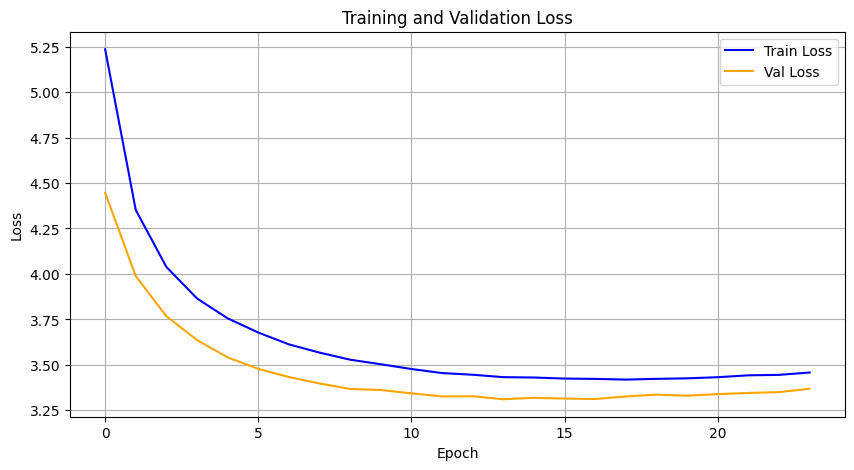

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(trainLosses, label='Train Loss', color='blue', linestyle='-')
plt.plot(valLosses, label='Val Loss', color='orange', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

_Visualize BLEU1, BLEU2, BLEU3, BLEU4 for Validation Data_

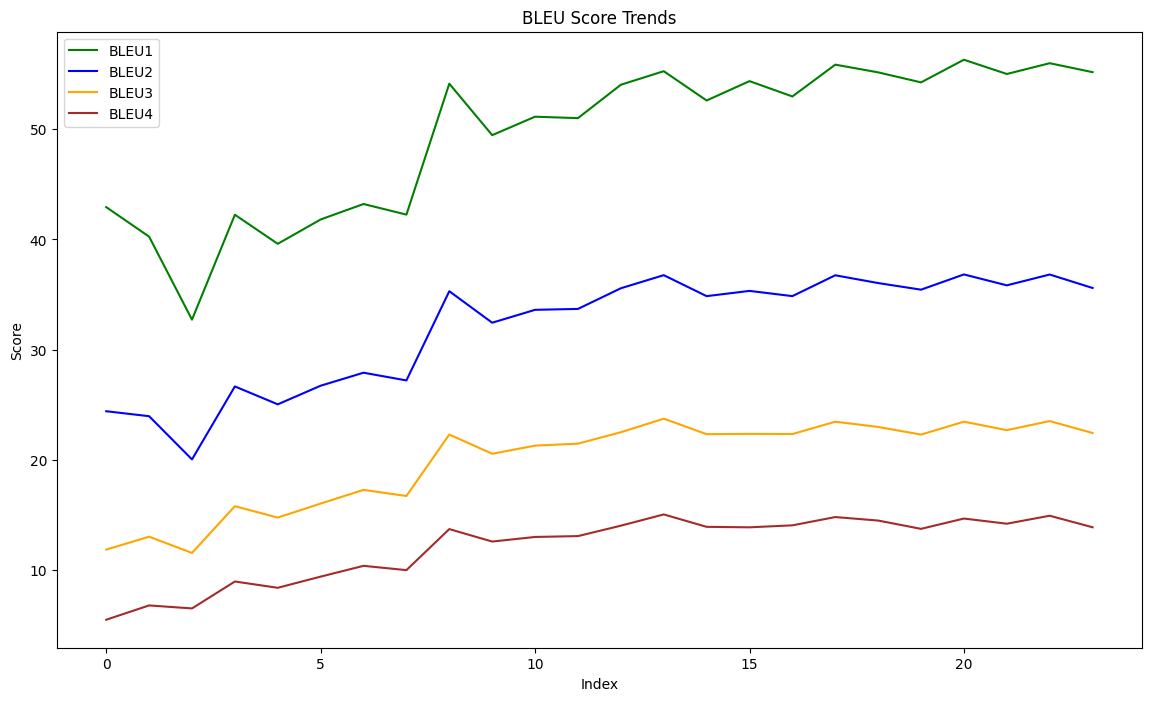

In [17]:
plt.figure(figsize=(14, 8))

plt.plot(bleu1Values, color='green', label='BLEU1')
plt.plot(bleu2Values, color='blue', label='BLEU2')
plt.plot(bleu3Values, color='orange', label='BLEU3')
plt.plot(bleu4Values, color='brown', label='BLEU4')

plt.legend()
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('BLEU Score Trends')
plt.show()

_Load Best Model_

In [ ]:
checkpoint = torch.load(
    os.path.join(modelsDir, 'bestmodel.pth'),
    map_location=device,
    weights_only=False
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ImageCaptionModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

_Write a Prediction Function_

In [ ]:
def predict(model, image, vocabulary, device, maxLength=50, beamSize=5):
    model.eval()
    
    # get start and end token ids from the vocabulary
    startToken = vocabulary.word2idx[vocabulary.START_TOKEN]
    endToken = vocabulary.word2idx[vocabulary.END_TOKEN]
    vocabSize = len(vocabulary)

    with torch.no_grad():
        # encode the image
        encoderOut = model.encoder(image.unsqueeze(0).to(device))
        
        # Get feature dimensions from encoder
        encoderDim = encoderOut.size(-1)
        numPixels = encoderOut.size(1)
        encoderOut = encoderOut.view(1, numPixels, encoderDim)

        # copy encoder output beamSize times so each beam gets its own copy
        encoderOut = encoderOut.expand(beamSize, numPixels, encoderDim)

        # Number of active beams (candidates)
        k = beamSize
        
        # start all sequences with the <start> token
        seqs = torch.full((k, 1), startToken, dtype=torch.long, device=device)
        
        # keep running scores for each beam
        topKScores = torch.zeros(k, device=device)
        
        # store attention weights (alphas) for each sequence
        seqsAlpha = [torch.empty((0, numPixels), device=device) for _ in range(k)]

        # lists to save completed sequences and their scores
        completeSeqs = []
        completeScores = []
        completeSeqsAlpha = []

        # initialize the decoder’s hidden and cell states
        h, c = model.decoder.initHiddenState(encoderOut)
        
        # keep track of how many decoding steps we’ve done
        step = 1
        # keep generating words until all sequences finish
        while True:
            # get embeddings of the last generated words for each sequence
            embeddings = model.decoder.embedding(seqs[:, -1])
            # apply attention mechanism to focus on image regions
            attentionWeightedEncoding, alpha = model.decoder.attention(encoderOut, h)
            # apply a gating scalar to control how much attention info is used
            gate = model.decoder.sigmoid(model.decoder.fBeta(h))
            attentionWeightedEncoding = gate * attentionWeightedEncoding

            # one decoding step: combine embeddings + attention + hidden states
            h, c = model.decoder.decodeStep(torch.cat([embeddings, attentionWeightedEncoding], dim=1), (h, c))
            # compute output scores
            scores = model.decoder.fc(model.decoder.dropoutLayer(h))
            # turn scores into log probabilities for easier math
            scores = F.log_softmax(scores, dim=1)

            # first step: only one sequence, so just pick top k words
            if step == 1:
                topKScores, topKWords = scores[0].topk(k, dim=0, largest=True)
                prevWordInds = torch.zeros(k, dtype=torch.long, device=device)
            else:
                # add previous scores to current log probs
                scores = scores + topKScores.unsqueeze(1)
                # flatten and pick the best k new sequences overall
                topKScores, topKWords = scores.view(-1).topk(k, dim=0, largest=True)
                # figure out which old sequence each new one came from
                prevWordInds = topKWords // vocabSize

            # find the actual next word indices for each beam
            nextWordInds = topKWords % vocabSize
            # append next words to their corresponding previous sequences
            seqs = torch.cat([seqs[prevWordInds], nextWordInds.unsqueeze(1)], dim=1)

            # update stored attention maps for each sequence
            newSeqsAlpha = []
            for idx, prevInd in enumerate(prevWordInds.tolist()):
                alphaSeq = torch.cat([seqsAlpha[prevInd], alpha[prevInd].unsqueeze(0)], dim=0)
                newSeqsAlpha.append(alphaSeq)
            seqsAlpha = newSeqsAlpha

            # reorder encoder output and hidden states to match surviving beams
            encoderOut = encoderOut[prevWordInds]
            h = h[prevWordInds]
            c = c[prevWordInds]

            # split finished vs unfinished sequences
            completeInds = []
            incompleteInds = []
            for ind, nextWord in enumerate(nextWordInds.tolist()):
                # a sequence is complete if it hits <end> or max length
                if nextWord == endToken or seqs[ind].size(0) >= maxLength:
                    completeInds.append(ind)
                else:
                    incompleteInds.append(ind)

            # save completed sequences and their scores
            if len(completeInds) > 0:
                completeSeqs.extend(seqs[completeInds].tolist())
                completeScores.extend(topKScores[completeInds])
                completeSeqsAlpha.extend([seqsAlpha[ind] for ind in completeInds])

            # reduce beam size for remaining incomplete sequences
            k -= len(completeInds)
            # stop if all sequences are done or max steps reached
            if k == 0 or step >= maxLength:
                break

            # keep only the incomplete sequences for next round
            seqs = seqs[incompleteInds]
            seqsAlpha = [seqsAlpha[ind] for ind in incompleteInds]
            encoderOut = encoderOut[incompleteInds]
            h = h[incompleteInds]
            c = c[incompleteInds]
            topKScores = topKScores[incompleteInds]

            # update beam count and move to next step
            k = len(seqs)
            # run one decoding step through LSTMCell
            h, c = self.decodeStep(
                torch.cat([currentEmbeddings, attentionWeightedEncoding], dim=1),
                (h[:batchSizeT], c[:batchSizeT])
            )
            completeScores = topKScores
            completeSeqsAlpha = seqsAlpha
        else:
            # stack all final scores into one tensor for argmax
            completeScores = torch.stack(completeScores)

        # pick the sequence with the highest final score
        if isinstance(completeScores, torch.Tensor):
            bestIdx = completeScores.argmax().item()
        else:
            bestIdx = np.argmax(completeScores)

        # get best sequence and its attention weights
        bestSeq = completeSeqs[bestIdx]
        bestAlpha = completeSeqsAlpha[bestIdx].detach().cpu().numpy()

    # convert token ids back to words until <end> token is reached
    tokens = []
    for idx in bestSeq[1:]:
        if idx == endToken:
            break
        tokens.append(vocabulary.idx2word[idx])
    return ' '.join(tokens), bestAlpha

_Inference on Model_

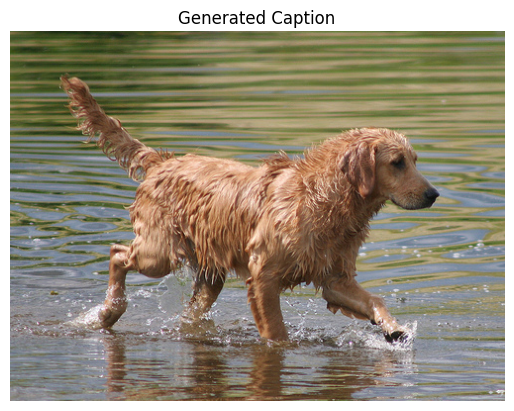

🖼️ Image: 2587017287_888c811b5a.jpg
🧠 Predicted: a brown dog is in the water
📜 Ground Truth: A big tan wet dog in shallow water .


In [20]:
imgName = random.choice(os.listdir(testImages))
imgPath = os.path.join(testImages, imgName)

image = Image.open(imgPath).convert('RGB')
imageTensor = evalTransform(image)

caption, alphas = predict(model, imageTensor, vocabulary, device)

capFile = os.path.splitext(imgName)[0] + '.txt'
capPath = os.path.join(testCaptions, capFile)
with open(capPath, 'r', encoding='utf-8') as f:
    gtCaptions = f.read().strip().split('\n')

plt.imshow(image)
plt.axis('off')
plt.title("Generated Caption")
plt.show()

print(f"🖼️ Image: {imgName}")
print(f"🧠 Predicted: {caption}")
print(f"📜 Ground Truth: {gtCaptions[0]}")

_Visualize Attention Weights_

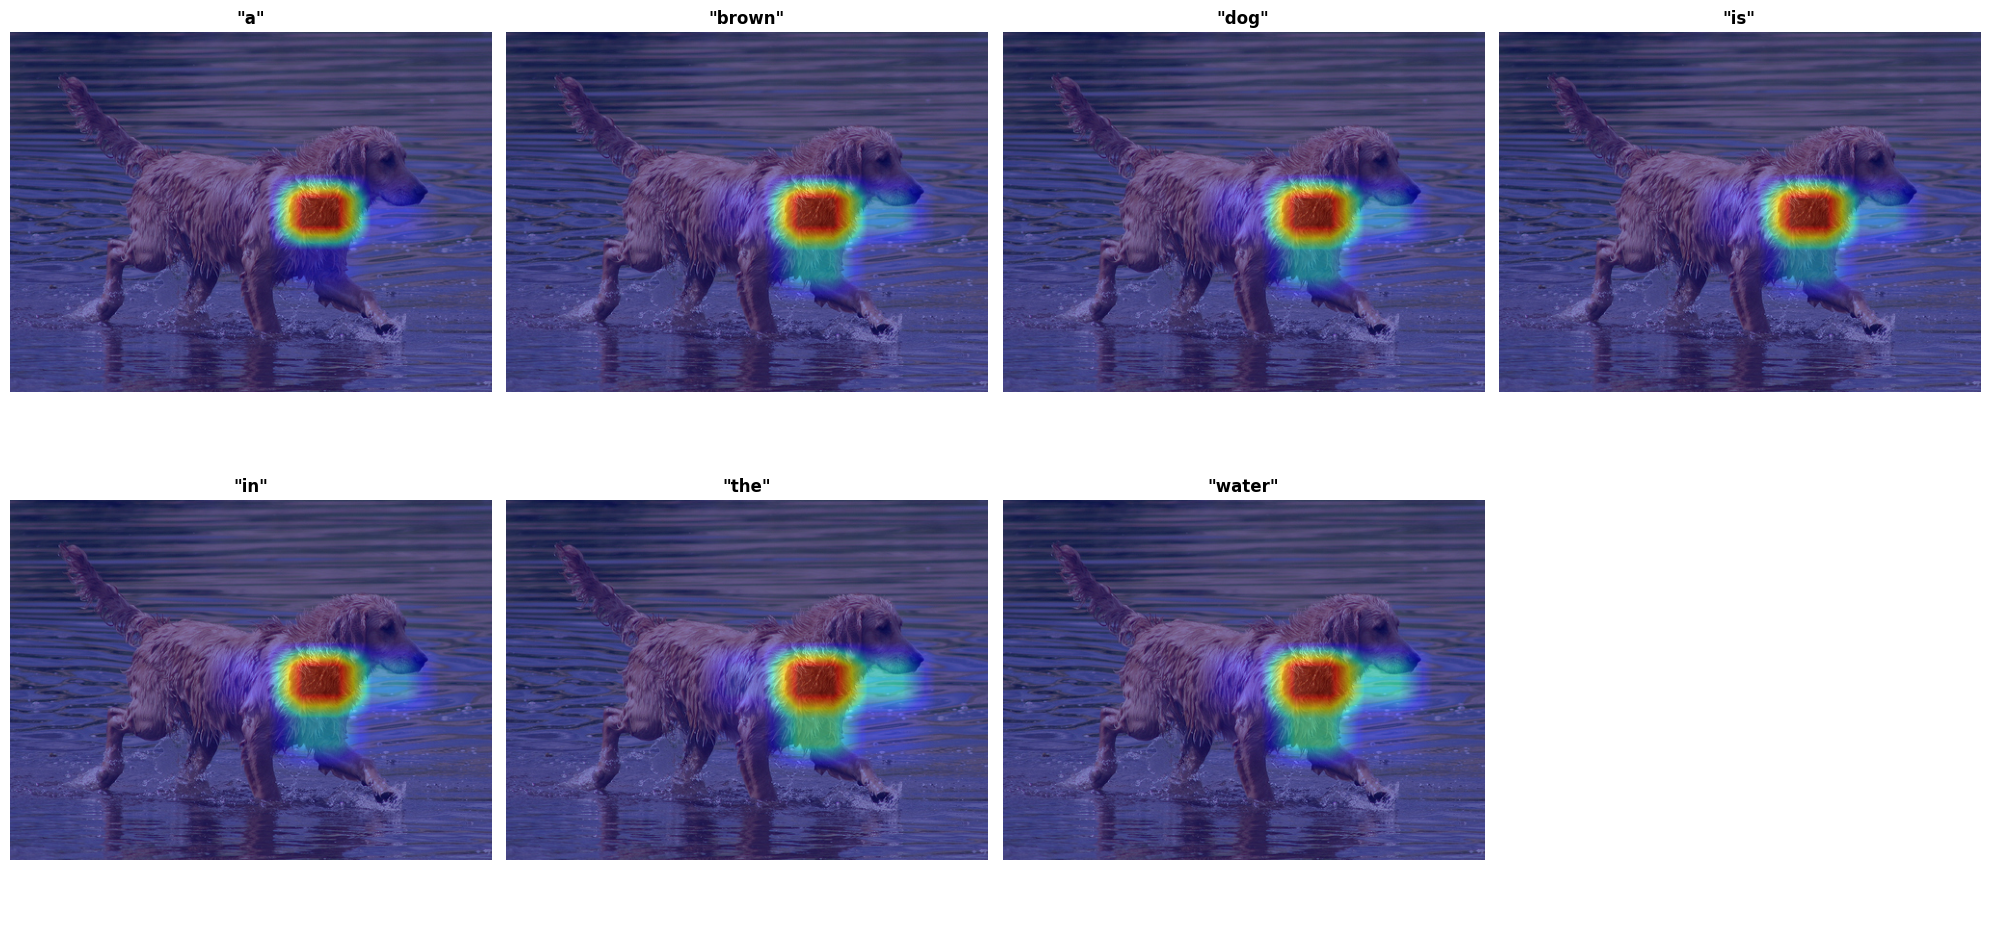

Caption: a brown dog is in the water
Number of words: 7
Number of attention maps: 8


In [21]:
words = caption.split()
imgWidth, imgHeight = image.size

# reshape attention weights
numSteps = alphas.shape[0]
attentionMaps = alphas.reshape(numSteps, 14, 14)

numVisualizations = min(len(words), numSteps)
# calculate number of rows and columns for subplots
numCols = 4
numRows = (numVisualizations + numCols - 1) // numCols

# create figure with subplots
fig, axes = plt.subplots(numRows, numCols, figsize=(20, 5 * numRows))
if numRows == 1:
    axes = axes.reshape(1, -1) if numVisualizations > 1 else axes.reshape(1, -1)
axes = axes.flatten()

# visualize attention for each word
for i in range(numVisualizations):
    # get attention map for this word
    attMap = attentionMaps[i]
    # normalize attention map to [0, 1]
    attMap = (attMap - attMap.min()) / (attMap.max() - attMap.min() + 1e-8)
    # convert to image for resizing
    attMapImg = Image.fromarray((attMap * 255).astype(np.uint8))
    # resize attention map to match image dimensions
    attMapResized = attMapImg.resize((imgWidth, imgHeight), Image.BILINEAR)
    attMapResized = np.array(attMapResized) / 255.0
    # display original image
    axes[i].imshow(image)
    # overlay attention heatmap
    axes[i].imshow(attMapResized, cmap='jet', alpha=0.5, interpolation='bilinear')
    
    if i < len(words):
        axes[i].set_title(f'"{words[i]}"', fontsize=12, fontweight='bold')
    else:
        axes[i].set_title(f'Step {i+1}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

for i in range(numVisualizations, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Caption: {caption}")
print(f"Number of words: {len(words)}")
print(f"Number of attention maps: {numSteps}")

_Load a Pre-Trained Image Captioning Model_

In [22]:
blipProcessor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blipModel = AutoModelForVision2Seq.from_pretrained("Salesforce/blip-image-captioning-base")
blipModel.to(device)

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

_Inference on BLIP Model_

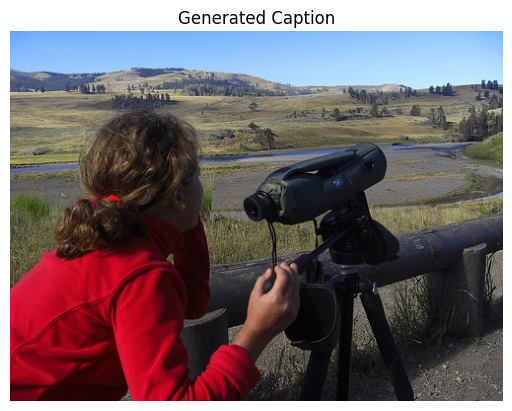

🖼️ Image: 2851304910_b5721199bc.jpg
🧠 Predicted: a woman wearing a red jacket
📜 Ground Truth: A photographer looks over the hills .


In [24]:
imgName = random.choice(os.listdir(testImages))
imgPath = os.path.join(testImages, imgName)
image = Image.open(imgPath).convert("RGB")

# preprocess and generate caption
inputs = blipProcessor(images=image, return_tensors="pt").to(device)
outputs = blipModel.generate(**inputs)
caption = blipProcessor.decode(outputs[0], skip_special_tokens=True)

# display image with caption
plt.imshow(image)
plt.axis('off')
plt.title("Generated Caption")
plt.show()

gtCaption = ""
capFile = os.path.splitext(imgName)[0] + '.txt'
capPath = os.path.join(testCaptions, capFile)
if os.path.exists(capPath):
    with open(capPath, 'r', encoding='utf-8') as f:
        gtCaption = f.read().strip().split('\n')[0]

print(f"🖼️ Image: {imgName}")
print(f"🧠 Predicted: {caption}")
print(f"📜 Ground Truth: {gtCaption}")

_Compare Models_

In [ ]:
bleu = BLEU()

modelScores = []
blipScores = []
print("Testing both model's performance...")
testImagesList = os.listdir(testImages)
for basename in tqdm(testImagesList, desc="Getting Results"):
    imgPath = os.path.join(testImages, basename)
    capFile = os.path.splitext(basename)[0] + '.txt'   # use basename!
    capPath = os.path.join(testCaptions, capFile)
    
    image = Image.open(imgPath).convert("RGB")
    imageTensor = evalTransform(image)
    
    with open(capPath, 'r', encoding='utf-8') as file:
        trueCaptions = [line.strip() for line in file.readlines() if line.strip()]

    # predict captions
    modelCaption, alphas = predict(model, imageTensor, vocabulary, device)
    inputs = blipProcessor(images=image, return_tensors="pt").to(device)
    outputs = blipModel.generate(**inputs)
    blipCaption = blipProcessor.decode(outputs[0], skip_special_tokens=True)

    # --- prepare references in the format sacrebleu wants ---
    refs = [[r] for r in trueCaptions] if len(trueCaptions) > 0 else [[""]]

    # compute BLEU (take numeric .score)
    modelScore = bleu.corpus_score([modelCaption], refs).score
    blipScore = bleu.corpus_score([blipCaption], refs).score

    modelScores.append(modelScore)
    blipScores.append(blipScore)

Testing both model's performance...


Getting Results: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]


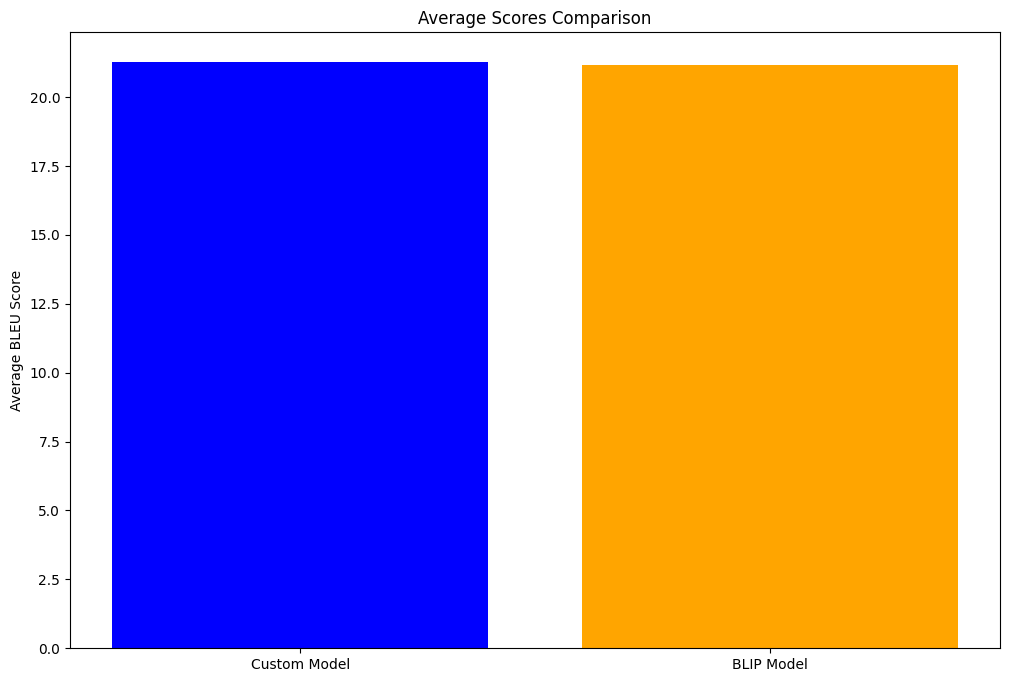

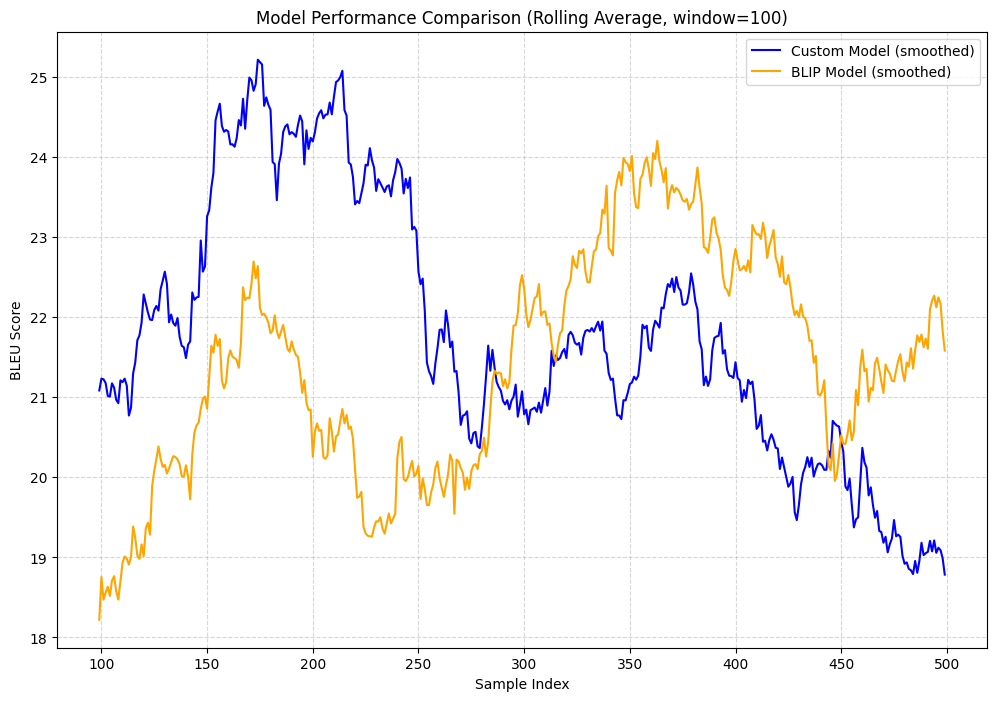

In [27]:
modelAvg = np.mean(modelScores)
blipAvg = np.mean(blipScores)

plt.figure(figsize=(12, 8))
models = ['Custom Model', 'BLIP Model']
averages = [modelAvg, blipAvg]
plt.bar(models, averages, color=['blue', 'orange'])
plt.title('Average Scores Comparison')
plt.ylabel('Average BLEU Score')
plt.show()

window = 100
modelSmooth = pd.Series(modelScores).rolling(window).mean()
blipSmooth = pd.Series(blipScores).rolling(window).mean()

plt.figure(figsize=(12, 8))
plt.plot(modelSmooth, color='blue', label='Custom Model (smoothed)')
plt.plot(blipSmooth, color='orange', label='BLIP Model (smoothed)')
plt.title(f'Model Performance Comparison (Rolling Average, window={window})')
plt.xlabel('Sample Index')
plt.ylabel('BLEU Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# end of the notebook, thank you for your time : )